In [74]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from constant import *
from helpers import *

### 1. Data Loading

In [2]:
DATA_DIR = '../res/recipes/'

In [3]:
# Collect all the recipes for all regions
recipes_lst = []
for filename in os.listdir(DATA_DIR):
  if filename.endswith('.txt'):
    recipes_lst += read_region_file(DATA_DIR+filename)

# Create the dataframe with all the recipes
recipes_df = pd.DataFrame(
  recipes_lst, 
  columns= ['subregion', 'recipe_name', 'ingredients_inferred', 'nb_persons', 'ingredients', 'recipe_body']
)

In [4]:
recipes_df.head()

,subregion,recipe_name,ingredients_inferred,nb_persons,ingredients,recipe_body
0,Alsace,LE KUGELHOPF,with,6,0.5 litre de lait\n500 g farine\n250 g beurre\...,Pour 6 personnes : Mettez dans une terrine 1/2...
1,Alsace,LE SCHWOWCBREDEL,with,6,500 g farine\n500 g sucre\n500 g amandes\n500 ...,Pour 6 personnes: Mélanger farine et beurre. R...
2,Alsace,PARFAIT DE FOIE GRAS STRASBOURGEOISE,with,-,1 kg foie gras oiseau\n1 truffe\n1 dl gelée\n1...,"1 kg de foie gras d’Alsace 1er qualité, dénerv..."
3,Alsace,TRUITES DE LA FECHT COLMARIENNE,with,4,4 truites\n8 écrevisses\n4 œufs\n50 g oignons\...,Pour 4 personnes: Prenez 4 belles truites du t...
4,Alsace,LES SCHANKELAS,with,-,375 g sucre\n250 g amandes\n200 g beurre\n250 ...,Ecraser le beurre avec la farine et bien mêler...


### 2. Data Processing

In [5]:
contents = collect_all_ingredient_contents(recipes_df)
print(len(contents))

632


In [6]:
contents

{'Béchamel',
 'Merluza',
 'Rouille',
 'SAUCE A LA RAVIGOTE',
 'SAUCE BERCY',
 'SAUCE BORDELAISE',
 'SAUCE PERIGUEUX',
 'SAUCE PIQUANTE',
 'SAUCE PRIEURE',
 'SAUCE QUERCYNOISE',
 'SAUCE TARTARE',
 'abatis oie ou canard',
 'abricots',
 'ail',
 'alcool Vermouth blanc',
 'alose',
 'alouette oiseau',
 'alouettes oiseau',
 'amandes',
 'amandes pilées',
 'anchois',
 'anguilles',
 'angélique',
 'angélique en poudre',
 'anis en grains',
 'aromate',
 'aromates',
 'artichaut',
 'aubergines',
 'bacon porc',
 'baies de genièvre',
 'baies genièvre',
 'bananes',
 'barbue ou turbot',
 'barde de lard porc',
 'barde de lard salé porc',
 'bardes de lard porc',
 'bardes lard porc',
 'bas morceaux de veau',
 'basilic',
 'baudruche de bœuf',
 'bette',
 'betteraves',
 'beurre',
 "beurre d'anchois",
 "beurre d'écrevisses",
 'beurre fin',
 'beurre tiède',
 'bicarbonate',
 'bière',
 "blanc d'œuf",
 'blanc de poireau',
 'blanc de poireaux',
 'blanc de poule',
 'blanc de volaille',
 'blancs de poireaux',
 'bouill

In [9]:
contents_multiset = ingredients_frequency(recipes_df)
{k: v for k, v in sorted(contents_multiset.items(), key=lambda item: item[1], reverse=True)}

{'beurre': 180,
 'sel': 167,
 'poivre': 146,
 'œufs': 101,
 'oignons': 95,
 'farine': 89,
 'persil': 82,
 'ail': 76,
 'vin blanc': 69,
 'bouquet garni': 46,
 'échalotes': 41,
 'carottes': 37,
 'champignons': 37,
 'laurier': 35,
 'lait': 33,
 "huile d'olive": 32,
 'citron': 31,
 'bouillon': 31,
 'sucre': 30,
 'thym': 28,
 'pommes de terre': 27,
 'vinaigre': 26,
 'estragon': 26,
 'huile': 25,
 'échalote': 24,
 'tomates': 24,
 'lard porc': 22,
 'muscade': 19,
 'vin rouge': 18,
 'truffe': 17,
 'crème fraîche': 17,
 'cerfeuil': 17,
 'jambon porc': 16,
 'épices': 15,
 'moutarde': 14,
 'mie de pain': 14,
 'crème': 14,
 'poulet': 13,
 'petits oignons': 13,
 'foie gras oiseau': 12,
 'crème double': 12,
 'céleri': 11,
 'gruyère': 11,
 'poireaux': 11,
 'eau-de-vie': 11,
 'sucre en poudre': 11,
 'écrevisses': 9,
 'pomme de terre': 9,
 'truffes': 9,
 'lardons porc': 9,
 'chapelure': 8,
 'pain': 8,
 'fines herbes': 8,
 'clou de girofle': 8,
 'gros oignons': 8,
 'piment rouge': 8,
 'clous de girofle'

In [10]:
set([k for (k, v) in contents_multiset.items() if v > 1])

{'SAUCE PIQUANTE',
 'ail',
 'alose',
 'amandes',
 'anchois',
 'anguilles',
 'artichaut',
 'aubergines',
 'barde de lard porc',
 'basilic',
 'beurre',
 'bière',
 "blanc d'œuf",
 'bouillon',
 'bouquet garni',
 'béchamel',
 'bœuf',
 'cailles',
 'canapés',
 'canard',
 'cannelle',
 'carottes',
 'carpes',
 'cerfeuil',
 'chair à saucisse viande',
 'champignons',
 'champignons de couche',
 'chapelure',
 'chocolat',
 'chorizo',
 'chou',
 'ciboule',
 'ciboulette',
 'ciboulettes',
 'cidre',
 'citron',
 'clou de girofle',
 'clous de girofle',
 'clous girofle',
 'coing',
 'consommé',
 'cornichons',
 'couenne de porc',
 'couennes de lard porc',
 'coulis de tomates',
 'crevettes',
 'croûton de pain',
 'croûtons',
 'croûtons frits',
 'crème',
 'crème Chantilly',
 'crème double',
 'crème fraîche',
 'curry',
 'câpres',
 'cèpes',
 'céleri',
 'côte de bœuf',
 'cœur céleri',
 'eau',
 'eau-de-vie',
 'eau-de-vie Armagnac',
 'eau-de-vie Calvados',
 'eau-de-vie Cognac',
 'eau-de-vie Kirsch',
 'eau-de-vie Mirab

In [15]:
collect_all_ingredient_contents(recipes_df.ingredients)

AttributeError: 'Series' object has no attribute 'iterrows'

In [16]:
recipes_df.ingredients[0]

'0.5 litre de lait\n500 g farine\n250 g beurre\n2 œufs\n125 g raisins Malaga\n6 cl eau-de-vie Kirsch\n125 g sucre\n25 g levure de boulanger\n1 pincée de sel\nquelques amandes'

In [36]:
recipes_analysis = recipes_df.copy()
recipes_analysis['content'] = ''
recipes_analysis['ingredient'] = ''
recipes_analysis['category'] = ''

In [ ]:
l = ['veau', 'poisson']
for i in l:
  

In [42]:
for k in Categories.keys():
  if 'veau' in Categories[k]:
    print(k)

Viande


In [50]:
for index, row in recipes_analysis.iterrows():
  content = []
  for ingredient in row['ingredients'].split('\n'):
    content.append(create_ingredient_tuple(ingredient))
  row['content'] = content
  row['ingredient'] = [c for (a, b, c) in row.content]
  category = []
  for i in row.ingredient:
    for k in Categories.keys():
      if i in Categories[k]:
        category.append(k)
  row['category'] = category
recipes_analysis

,subregion,recipe_name,ingredients_inferred,nb_persons,ingredients,recipe_body,content,ingredient,category
0,Alsace,LE KUGELHOPF,with,6,0.5 litre de lait\n500 g farine\n250 g beurre\...,Pour 6 personnes : Mettez dans une terrine 1/2...,"[(0.5, litre, lait), (500, g, farine), (250, g...","[lait, farine, beurre, œufs, raisins Malaga, e...","[Produit laitier, Céréale, Epice]"
1,Alsace,LE SCHWOWCBREDEL,with,6,500 g farine\n500 g sucre\n500 g amandes\n500 ...,Pour 6 personnes: Mélanger farine et beurre. R...,"[(500, g, farine), (500, g, sucre), (500, g, a...","[farine, sucre, amandes, beurre, écorce orange...",[Céréale]
2,Alsace,PARFAIT DE FOIE GRAS STRASBOURGEOISE,with,-,1 kg foie gras oiseau\n1 truffe\n1 dl gelée\n1...,"1 kg de foie gras d’Alsace 1er qualité, dénerv...","[(1, kg, foie gras oiseau), (1, -, truffe), (1...","[foie gras oiseau, truffe, gelée, beurre]",[Champignon]
3,Alsace,TRUITES DE LA FECHT COLMARIENNE,with,4,4 truites\n8 écrevisses\n4 œufs\n50 g oignons\...,Pour 4 personnes: Prenez 4 belles truites du t...,"[(4, -, truites), (8, -, écrevisses), (4, -, œ...","[truites, écrevisses, œufs, oignons, vin blanc...","[Plante aromatique, Plante aromatique, Plante ..."
4,Alsace,LES SCHANKELAS,with,-,375 g sucre\n250 g amandes\n200 g beurre\n250 ...,Ecraser le beurre avec la farine et bien mêler...,"[(375, g, sucre), (250, g, amandes), (200, g, ...","[sucre, amandes, beurre, farine, œufs, citron,...","[Céréale, Agrume, Agrume]"
...,...,...,...,...,...,...,...,...,...
347,Lyon,"FEUILLETE AUX ORONGES ET AUX ECREVISSES, MARTELIN",without,6,écrevisse\nvin blanc\nlégumes\nvelouté de vola...,Pour 6 personnes : Faire sauter et cardinalise...,"[(-, -, écrevisse), (-, -, vin blanc), (-, -, ...","[écrevisse, vin blanc, légumes, velouté de vol...","[Fruit de mer, Légume, Plante aromatique, Epice]"
348,Lyon,GRAS-DOUBLE SAUTE LYONNAISE,with,6,1 kg gras-double bœuf\n2 gros oignons\n6 cl hu...,Pour 6 personnes : Emincer le gras-double en g...,"[(1, kg, gras-double bœuf), (2, -, gros oignon...","[gras-double bœuf, gros oignons, huile, beurre...","[Epice, Epice, Plante aromatique]"
349,Lyon,LA GALETTE LYONNAISE,with,4-5,10 pommes de terre\n150 g beurre\n3 oignons\ns...,Pour 4 ou 5 personnes : Préparer une purée de ...,"[(10, -, pommes de terre), (150, g, beurre), (...","[pommes de terre, beurre, oignons, sel, poivre...","[Légume, Epice, Epice, Epice]"
350,Lyon,LE SALADIER LYONNAIS,with,4,1 pied mouton\n1 foie volaille\n3 œufs\n2 hare...,Pour 4 personnes : Faire une vinaigrette bien ...,"[(1, -, pied mouton), (1, -, foie volaille), (...","[pied mouton, foie volaille, œufs, harengs mar...","[Plante aromatique, Plante aromatique, Plante ..."


In [86]:
bycat = recipes_analysis.groupby('subregion')['category'].sum().reset_index()
bycat['category_set'] = bycat['category'].apply(lambda x: set(x))
bycat['cat_num'] = bycat['category'].apply(lambda x: len(x))
bycat

,subregion,category,category_set,cat_num
0,Alsace,"[Produit laitier, Céréale, Epice, Céréale, Cha...","{Champignon, Epice, Produit laitier, Plante ar...",18
1,Anjou,"[Epice, Epice, Epice, Viande, Epice, Epice, Pl...","{Champignon, Epice, Poisson, Plante aromatique...",46
2,Auvergne,"[Produit laitier, Produit laitier, Epice, Epic...","{Champignon, Epice, Produit laitier, Plante ar...",23
3,Bordelais,"[Céréale, Champignon, Agrume, Epice, Céréale, ...","{Champignon, Epice, Poisson, Plante aromatique...",22
4,Bourgogne,"[Plante aromatique, Légume, Epice, Epice, Epic...","{Epice, Plante aromatique, Produit laitier, Cé...",53
5,Bresse,"[Céréale, Produit laitier, Epice, Epice, Produ...","{Champignon, Epice, Produit laitier, Plante ar...",39
6,Bretagne,"[Légume, Agrume, Plante aromatique, Plante aro...","{Epice, Poisson, Plante aromatique, Produit la...",88
7,Champagne,"[Plante aromatique, Plante aromatique, Plante ...","{Champignon, Epice, Poisson, Plante aromatique...",27
8,Charentes,"[Céréale, Plante aromatique, Agrume, Plante ar...","{Plante aromatique, Agrume, Céréale, Epice}",46
9,Corse,"[Epice, Epice, Plante aromatique, Plante aroma...","{Epice, Plante aromatique, Céréale, Légume, Vi...",11


<AxesSubplot:title={'center':'Distribution of number of different categories used by per region'}, ylabel='Frequency'>

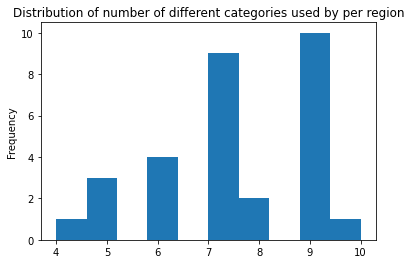

In [72]:
bycat.cat_num.plot(kind='hist',
  title='Distribution of number of different categories used by per region',
  xlabel='Number of categories')

In [87]:
bying = recipes_analysis.groupby('subregion')['ingredient'].sum().reset_index()
bying['ingredient_set'] = bying['ingredient'].apply(lambda x: set(x))
bying['ing_num'] = bying['ingredient'].apply(lambda x: len(x))
bying

,subregion,ingredient,ingredient_set,ing_num
0,Alsace,"[lait, farine, beurre, œufs, raisins Malaga, e...","{eau fleur d'oranger, poivre, œufs, sel, sucre...",67
1,Anjou,"[échalotes, beurre, vin blanc, filet porc, lar...","{pissenlit, poivre, œufs, porc, laitue, sel, s...",100
2,Auvergne,"[truites, beurre, alcool Vermouth blanc, œufs,...","{poivre, œufs, sel, truffe, sucre, beurre, lar...",55
3,Bordelais,"[farine, levure, œufs, beurre, sucre, fleurs d...","{poivre, œufs, zeste de citron, laitue, sel, s...",75
4,Bourgogne,"[perdrix oiseau, champignons, lard porc, jambo...","{vin blanc sec, chou pommé, chou, bouillon, vi...",147
5,Bresse,"[chair de brochet, beurre, œufs, farine, lait,...","{poivre, œufs, sel, truffe, échalote, beurre, ...",90
6,Bretagne,"[laitance carpes, thon nouveau, échalote, beur...","{poivre, couenne de lard porc, œufs, sel, écha...",172
7,Champagne,"[épaule et palette porc, bouillon, vin blanc, ...","{poivre, sel, truffe, petit oignon, échalote, ...",66
8,Charentes,"[moules, beurre, farine, ail, œuf, citron, per...","{poivre, œufs, sel, sucre, épices, beurre, cer...",103
9,Corse,"[merle oiseau, filet de porc, foie de porc, pa...","{poivre, levain salé, sel, sucre, beurre, lard...",35


<AxesSubplot:title={'center':'Distribution of number of different ingredients used by per region'}, ylabel='Frequency'>

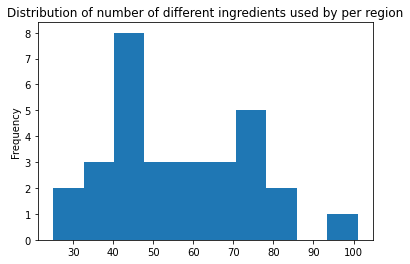

In [73]:
bying.ing_num.plot(kind='hist',
  title='Distribution of number of different ingredients used by per region',
  xlabel='Number of ingredients')

/var/folders/0b/bgz3jw612mb5qgn0nyrrygzc0000gn/T/ipykernel_1783/2862412127.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  glue = sns.load_dataset("glue").pivot("Model", "Task", "Score")


<AxesSubplot:xlabel='Task', ylabel='Model'>

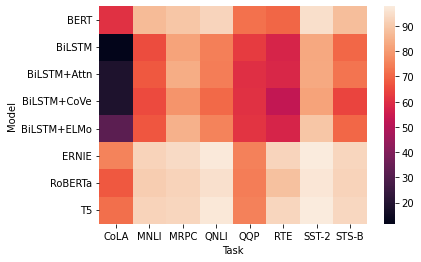

In [75]:
glue = sns.load_dataset("glue").pivot("Model", "Task", "Score")
sns.heatmap(glue)

In [92]:
bycat

,subregion,category,category_set,cat_num
0,Alsace,"[Produit laitier, Céréale, Epice, Céréale, Cha...","{Champignon, Epice, Produit laitier, Plante ar...",18
1,Anjou,"[Epice, Epice, Epice, Viande, Epice, Epice, Pl...","{Champignon, Epice, Poisson, Plante aromatique...",46
2,Auvergne,"[Produit laitier, Produit laitier, Epice, Epic...","{Champignon, Epice, Produit laitier, Plante ar...",23
3,Bordelais,"[Céréale, Champignon, Agrume, Epice, Céréale, ...","{Champignon, Epice, Poisson, Plante aromatique...",22
4,Bourgogne,"[Plante aromatique, Légume, Epice, Epice, Epic...","{Epice, Plante aromatique, Produit laitier, Cé...",53
5,Bresse,"[Céréale, Produit laitier, Epice, Epice, Produ...","{Champignon, Epice, Produit laitier, Plante ar...",39
6,Bretagne,"[Légume, Agrume, Plante aromatique, Plante aro...","{Epice, Poisson, Plante aromatique, Produit la...",88
7,Champagne,"[Plante aromatique, Plante aromatique, Plante ...","{Champignon, Epice, Poisson, Plante aromatique...",27
8,Charentes,"[Céréale, Plante aromatique, Agrume, Plante ar...","{Plante aromatique, Agrume, Céréale, Epice}",46
9,Corse,"[Epice, Epice, Plante aromatique, Plante aroma...","{Epice, Plante aromatique, Céréale, Légume, Vi...",11


In [120]:
heatmap_df = pd.DataFrame(0, columns=Categories.keys(), index=recipes_df.subregion.unique())
for index, row in bycat.iterrows():
  new_row = heatmap_df.loc[row.subregion]
  for c in row.category:
    new_row[c] += 1
heatmap_df

,Viande,Poisson,Fruit de mer,Alcool,Plante aromatique,Epice,Produit laitier,Légume,Fruit,Agrume,Céréale,Légumineuse,Fruit sec,Champignon
Alsace,0,0,0,0,3,2,2,1,1,2,6,0,0,1
Limousin,4,0,0,0,10,15,2,4,0,0,3,0,0,1
Bretagne,1,3,0,0,26,32,8,8,0,5,5,0,0,0
Provence,0,4,0,0,27,16,3,6,0,1,3,0,0,0
Anjou,4,2,0,0,7,21,2,3,0,1,5,0,0,1
Normandie,4,0,1,2,12,30,4,8,0,8,5,0,0,1
Bordelais,0,1,0,0,9,5,0,0,0,2,4,0,0,1
Nord,7,0,0,1,13,9,1,9,0,1,4,0,0,1
Franche-Comté,3,2,0,0,9,25,3,1,1,3,4,0,0,0
Corse,1,0,0,0,2,6,0,1,0,0,1,0,0,0


<AxesSubplot:>

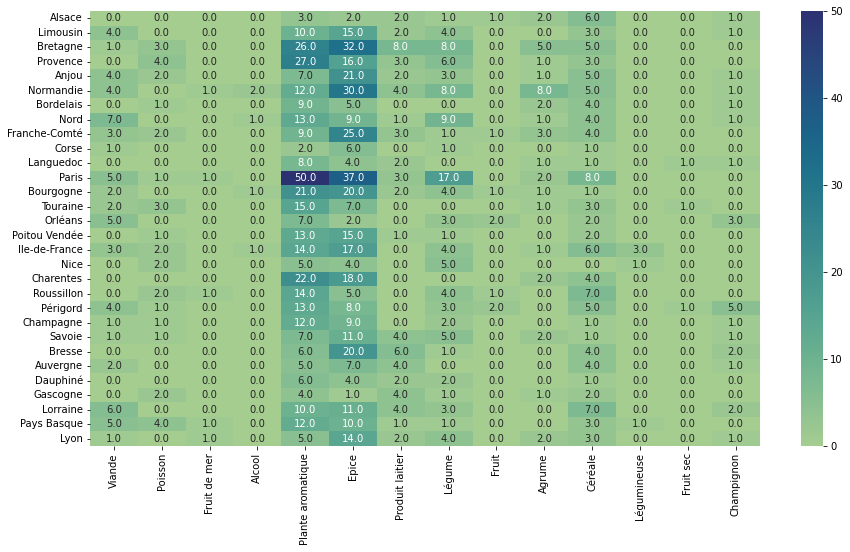

In [127]:
plt.figure(figsize=(15,8))
# plt.title('Heatmap of categories by region')
sns.heatmap(heatmap_df, cmap="crest", annot=True, fmt=".1f")